# The Multi-Color Prophet Problem notebook

 Contact: p.praat@student.uva.nl

In [7]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.stats import uniform
from numpy.random import default_rng
from collections import Counter
import matplotlib.pyplot as plt
from statistics import mean

rng = default_rng()

In [1]:
diff_solution_50 = [1.00E+00, 9.73E-01, 9.45E-01, 9.18E-01, 8.91E-01, 8.63E-01, 8.36E-01,
      8.09E-01, 7.82E-01, 7.56E-01, 7.29E-01, 7.03E-01, 6.76E-01, 6.50E-01,
      6.24E-01, 5.99E-01, 5.74E-01, 5.49E-01, 5.24E-01, 4.99E-01, 4.75E-01,
      4.52E-01, 4.28E-01, 4.05E-01, 3.83E-01, 3.61E-01, 3.39E-01, 3.18E-01,
      2.98E-01, 2.77E-01, 2.58E-01, 2.39E-01, 2.20E-01, 2.02E-01, 1.85E-01,
      1.68E-01, 1.52E-01, 1.36E-01, 1.21E-01, 1.07E-01, 9.32E-02, 8.02E-02,
      6.78E-02, 5.60E-02, 4.50E-02, 3.46E-02, 2.49E-02, 1.59E-02, 7.65E-03,
      1.95E-04]

diff_solution_1000 = [
      1.00E+00, 9.99E-01, 9.97E-01, 9.96E-01, 9.95E-01, 9.93E-01, 9.92E-01,
      9.91E-01, 9.89E-01, 9.88E-01, 9.87E-01, 9.85E-01, 9.84E-01, 9.83E-01,
      9.81E-01, 9.80E-01, 9.79E-01, 9.77E-01, 9.76E-01, 9.74E-01, 9.73E-01,
      9.72E-01, 9.70E-01, 9.69E-01, 9.68E-01, 9.66E-01, 9.65E-01, 9.64E-01,
      9.62E-01, 9.61E-01, 9.60E-01, 9.58E-01, 9.57E-01, 9.56E-01, 9.54E-01,
      9.53E-01, 9.52E-01, 9.50E-01, 9.49E-01, 9.48E-01, 9.46E-01, 9.45E-01,
      9.44E-01, 9.42E-01, 9.41E-01, 9.40E-01, 9.38E-01, 9.37E-01, 9.36E-01,
      9.34E-01, 9.33E-01, 9.32E-01, 9.30E-01, 9.29E-01, 9.28E-01, 9.26E-01,
      9.25E-01, 9.24E-01, 9.22E-01, 9.21E-01, 9.20E-01, 9.18E-01, 9.17E-01,
      9.16E-01, 9.14E-01, 9.13E-01, 9.11E-01, 9.10E-01, 9.09E-01, 9.07E-01,
      9.06E-01, 9.05E-01, 9.03E-01, 9.02E-01, 9.01E-01, 8.99E-01, 8.98E-01,
      8.97E-01, 8.95E-01, 8.94E-01, 8.93E-01, 8.91E-01, 8.90E-01, 8.89E-01,
      8.87E-01, 8.86E-01, 8.85E-01, 8.83E-01, 8.82E-01, 8.81E-01, 8.79E-01,
      8.78E-01, 8.77E-01, 8.75E-01, 8.74E-01, 8.73E-01, 8.71E-01, 8.70E-01,
      8.69E-01, 8.67E-01, 8.66E-01, 8.65E-01, 8.63E-01, 8.62E-01, 8.61E-01,
      8.59E-01, 8.58E-01, 8.57E-01, 8.55E-01, 8.54E-01, 8.53E-01, 8.51E-01,
      8.50E-01, 8.49E-01, 8.47E-01, 8.46E-01, 8.45E-01, 8.43E-01, 8.42E-01,
      8.41E-01, 8.39E-01, 8.38E-01, 8.37E-01, 8.35E-01, 8.34E-01, 8.33E-01,
      8.31E-01, 8.30E-01, 8.29E-01, 8.28E-01, 8.26E-01, 8.25E-01, 8.24E-01,
      8.22E-01, 8.21E-01, 8.20E-01, 8.18E-01, 8.17E-01, 8.16E-01, 8.14E-01,
      8.13E-01, 8.12E-01, 8.10E-01, 8.09E-01, 8.08E-01, 8.06E-01, 8.05E-01,
      8.04E-01, 8.02E-01, 8.01E-01, 8.00E-01, 7.98E-01, 7.97E-01, 7.96E-01,
      7.94E-01, 7.93E-01, 7.92E-01, 7.90E-01, 7.89E-01, 7.88E-01, 7.87E-01,
      7.85E-01, 7.84E-01, 7.83E-01, 7.81E-01, 7.80E-01, 7.79E-01, 7.77E-01,
      7.76E-01, 7.75E-01, 7.73E-01, 7.72E-01, 7.71E-01, 7.69E-01, 7.68E-01,
      7.67E-01, 7.65E-01, 7.64E-01, 7.63E-01, 7.62E-01, 7.60E-01, 7.59E-01,
      7.58E-01, 7.56E-01, 7.55E-01, 7.54E-01, 7.52E-01, 7.51E-01, 7.50E-01,
      7.48E-01, 7.47E-01, 7.46E-01, 7.45E-01, 7.43E-01, 7.42E-01, 7.41E-01,
      7.39E-01, 7.38E-01, 7.37E-01, 7.35E-01, 7.34E-01, 7.33E-01, 7.31E-01,
      7.30E-01, 7.29E-01, 7.28E-01, 7.26E-01, 7.25E-01, 7.24E-01, 7.22E-01,
      7.21E-01, 7.20E-01, 7.18E-01, 7.17E-01, 7.16E-01, 7.15E-01, 7.13E-01,
      7.12E-01, 7.11E-01, 7.09E-01, 7.08E-01, 7.07E-01, 7.06E-01, 7.04E-01,
      7.03E-01, 7.02E-01, 7.00E-01, 6.99E-01, 6.98E-01, 6.96E-01, 6.95E-01,
      6.94E-01, 6.93E-01, 6.91E-01, 6.90E-01, 6.89E-01, 6.87E-01, 6.86E-01,
      6.85E-01, 6.84E-01, 6.82E-01, 6.81E-01, 6.80E-01, 6.78E-01, 6.77E-01,
      6.76E-01, 6.75E-01, 6.73E-01, 6.72E-01, 6.71E-01, 6.69E-01, 6.68E-01,
      6.67E-01, 6.66E-01, 6.64E-01, 6.63E-01, 6.62E-01, 6.61E-01, 6.59E-01,
      6.58E-01, 6.57E-01, 6.55E-01, 6.54E-01, 6.53E-01, 6.52E-01, 6.50E-01,
      6.49E-01, 6.48E-01, 6.47E-01, 6.45E-01, 6.44E-01, 6.43E-01, 6.41E-01,
      6.40E-01, 6.39E-01, 6.38E-01, 6.36E-01, 6.35E-01, 6.34E-01, 6.33E-01,
      6.31E-01, 6.30E-01, 6.29E-01, 6.28E-01, 6.26E-01, 6.25E-01, 6.24E-01,
      6.22E-01, 6.21E-01, 6.20E-01, 6.19E-01, 6.17E-01, 6.16E-01, 6.15E-01,
      6.14E-01, 6.12E-01, 6.11E-01, 6.10E-01, 6.09E-01, 6.07E-01, 6.06E-01,
      6.05E-01, 6.04E-01, 6.02E-01, 6.01E-01, 6.00E-01, 5.99E-01, 5.97E-01,
      5.96E-01, 5.95E-01, 5.94E-01, 5.92E-01, 5.91E-01, 5.90E-01, 5.89E-01,
      5.87E-01, 5.86E-01, 5.85E-01, 5.84E-01, 5.82E-01, 5.81E-01, 5.80E-01,
      5.79E-01, 5.78E-01, 5.76E-01, 5.75E-01, 5.74E-01, 5.73E-01, 5.71E-01,
      5.70E-01, 5.69E-01, 5.68E-01, 5.66E-01, 5.65E-01, 5.64E-01, 5.63E-01,
      5.61E-01, 5.60E-01, 5.59E-01, 5.58E-01, 5.57E-01, 5.55E-01, 5.54E-01,
      5.53E-01, 5.52E-01, 5.50E-01, 5.49E-01, 5.48E-01, 5.47E-01, 5.46E-01,
      5.44E-01, 5.43E-01, 5.42E-01, 5.41E-01, 5.40E-01, 5.38E-01, 5.37E-01,
      5.36E-01, 5.35E-01, 5.33E-01, 5.32E-01, 5.31E-01, 5.30E-01, 5.29E-01,
      5.27E-01, 5.26E-01, 5.25E-01, 5.24E-01, 5.23E-01, 5.21E-01, 5.20E-01,
      5.19E-01, 5.18E-01, 5.17E-01, 5.15E-01, 5.14E-01, 5.13E-01, 5.12E-01,
      5.11E-01, 5.09E-01, 5.08E-01, 5.07E-01, 5.06E-01, 5.05E-01, 5.03E-01,
      5.02E-01, 5.01E-01, 5.00E-01, 4.99E-01, 4.97E-01, 4.96E-01, 4.95E-01,
      4.94E-01, 4.93E-01, 4.92E-01, 4.90E-01, 4.89E-01, 4.88E-01, 4.87E-01,
      4.86E-01, 4.84E-01, 4.83E-01, 4.82E-01, 4.81E-01, 4.80E-01, 4.79E-01,
      4.77E-01, 4.76E-01, 4.75E-01, 4.74E-01, 4.73E-01, 4.72E-01, 4.70E-01,
      4.69E-01, 4.68E-01, 4.67E-01, 4.66E-01, 4.65E-01, 4.63E-01, 4.62E-01,
      4.61E-01, 4.60E-01, 4.59E-01, 4.58E-01, 4.56E-01, 4.55E-01, 4.54E-01,
      4.53E-01, 4.52E-01, 4.51E-01, 4.50E-01, 4.48E-01, 4.47E-01, 4.46E-01,
      4.45E-01, 4.44E-01, 4.43E-01, 4.41E-01, 4.40E-01, 4.39E-01, 4.38E-01,
      4.37E-01, 4.36E-01, 4.35E-01, 4.34E-01, 4.32E-01, 4.31E-01, 4.30E-01,
      4.29E-01, 4.28E-01, 4.27E-01, 4.26E-01, 4.24E-01, 4.23E-01, 4.22E-01,
      4.21E-01, 4.20E-01, 4.19E-01, 4.18E-01, 4.17E-01, 4.15E-01, 4.14E-01,
      4.13E-01, 4.12E-01, 4.11E-01, 4.10E-01, 4.09E-01, 4.08E-01, 4.06E-01,
      4.05E-01, 4.04E-01, 4.03E-01, 4.02E-01, 4.01E-01, 4.00E-01, 3.99E-01,
      3.98E-01, 3.96E-01, 3.95E-01, 3.94E-01, 3.93E-01, 3.92E-01, 3.91E-01,
      3.90E-01, 3.89E-01, 3.88E-01, 3.87E-01, 3.85E-01, 3.84E-01, 3.83E-01,
      3.82E-01, 3.81E-01, 3.80E-01, 3.79E-01, 3.78E-01, 3.77E-01, 3.76E-01,
      3.75E-01, 3.74E-01, 3.72E-01, 3.71E-01, 3.70E-01, 3.69E-01, 3.68E-01,
      3.67E-01, 3.66E-01, 3.65E-01, 3.64E-01, 3.63E-01, 3.62E-01, 3.61E-01,
      3.60E-01, 3.58E-01, 3.57E-01, 3.56E-01, 3.55E-01, 3.54E-01, 3.53E-01,
      3.52E-01, 3.51E-01, 3.50E-01, 3.49E-01, 3.48E-01, 3.47E-01, 3.46E-01,
      3.45E-01, 3.44E-01, 3.43E-01, 3.41E-01, 3.40E-01, 3.39E-01, 3.38E-01,
      3.37E-01, 3.36E-01, 3.35E-01, 3.34E-01, 3.33E-01, 3.32E-01, 3.31E-01,
      3.30E-01, 3.29E-01, 3.28E-01, 3.27E-01, 3.26E-01, 3.25E-01, 3.24E-01,
      3.23E-01, 3.22E-01, 3.21E-01, 3.20E-01, 3.19E-01, 3.18E-01, 3.17E-01,
      3.16E-01, 3.15E-01, 3.14E-01, 3.13E-01, 3.12E-01, 3.10E-01, 3.09E-01,
      3.08E-01, 3.07E-01, 3.06E-01, 3.05E-01, 3.04E-01, 3.03E-01, 3.02E-01,
      3.01E-01, 3.00E-01, 2.99E-01, 2.98E-01, 2.97E-01, 2.96E-01, 2.95E-01,
      2.94E-01, 2.93E-01, 2.92E-01, 2.91E-01, 2.90E-01, 2.89E-01, 2.88E-01,
      2.87E-01, 2.86E-01, 2.85E-01, 2.84E-01, 2.84E-01, 2.83E-01, 2.82E-01,
      2.81E-01, 2.80E-01, 2.79E-01, 2.78E-01, 2.77E-01, 2.76E-01, 2.75E-01,
      2.74E-01, 2.73E-01, 2.72E-01, 2.71E-01, 2.70E-01, 2.69E-01, 2.68E-01,
      2.67E-01, 2.66E-01, 2.65E-01, 2.64E-01, 2.63E-01, 2.62E-01, 2.61E-01,
      2.60E-01, 2.59E-01, 2.58E-01, 2.57E-01, 2.56E-01, 2.56E-01, 2.55E-01,
      2.54E-01, 2.53E-01, 2.52E-01, 2.51E-01, 2.50E-01, 2.49E-01, 2.48E-01,
      2.47E-01, 2.46E-01, 2.45E-01, 2.44E-01, 2.43E-01, 2.42E-01, 2.41E-01,
      2.41E-01, 2.40E-01, 2.39E-01, 2.38E-01, 2.37E-01, 2.36E-01, 2.35E-01,
      2.34E-01, 2.33E-01, 2.32E-01, 2.31E-01, 2.30E-01, 2.30E-01, 2.29E-01,
      2.28E-01, 2.27E-01, 2.26E-01, 2.25E-01, 2.24E-01, 2.23E-01, 2.22E-01,
      2.21E-01, 2.21E-01, 2.20E-01, 2.19E-01, 2.18E-01, 2.17E-01, 2.16E-01,
      2.15E-01, 2.14E-01, 2.13E-01, 2.13E-01, 2.12E-01, 2.11E-01, 2.10E-01,
      2.09E-01, 2.08E-01, 2.07E-01, 2.06E-01, 2.06E-01, 2.05E-01, 2.04E-01,
      2.03E-01, 2.02E-01, 2.01E-01, 2.00E-01, 1.99E-01, 1.99E-01, 1.98E-01,
      1.97E-01, 1.96E-01, 1.95E-01, 1.94E-01, 1.93E-01, 1.93E-01, 1.92E-01,
      1.91E-01, 1.90E-01, 1.89E-01, 1.88E-01, 1.87E-01, 1.87E-01, 1.86E-01,
      1.85E-01, 1.84E-01, 1.83E-01, 1.82E-01, 1.82E-01, 1.81E-01, 1.80E-01,
      1.79E-01, 1.78E-01, 1.77E-01, 1.77E-01, 1.76E-01, 1.75E-01, 1.74E-01,
      1.73E-01, 1.73E-01, 1.72E-01, 1.71E-01, 1.70E-01, 1.69E-01, 1.68E-01,
      1.68E-01, 1.67E-01, 1.66E-01, 1.65E-01, 1.64E-01, 1.64E-01, 1.63E-01,
      1.62E-01, 1.61E-01, 1.60E-01, 1.60E-01, 1.59E-01, 1.58E-01, 1.57E-01,
      1.56E-01, 1.56E-01, 1.55E-01, 1.54E-01, 1.53E-01, 1.53E-01, 1.52E-01,
      1.51E-01, 1.50E-01, 1.49E-01, 1.49E-01, 1.48E-01, 1.47E-01, 1.46E-01,
      1.46E-01, 1.45E-01, 1.44E-01, 1.43E-01, 1.43E-01, 1.42E-01, 1.41E-01,
      1.40E-01, 1.39E-01, 1.39E-01, 1.38E-01, 1.37E-01, 1.36E-01, 1.36E-01,
      1.35E-01, 1.34E-01, 1.33E-01, 1.33E-01, 1.32E-01, 1.31E-01, 1.31E-01,
      1.30E-01, 1.29E-01, 1.28E-01, 1.28E-01, 1.27E-01, 1.26E-01, 1.25E-01,
      1.25E-01, 1.24E-01, 1.23E-01, 1.22E-01, 1.22E-01, 1.21E-01, 1.20E-01,
      1.20E-01, 1.19E-01, 1.18E-01, 1.17E-01, 1.17E-01, 1.16E-01, 1.15E-01,
      1.15E-01, 1.14E-01, 1.13E-01, 1.13E-01, 1.12E-01, 1.11E-01, 1.10E-01,
      1.10E-01, 1.09E-01, 1.08E-01, 1.08E-01, 1.07E-01, 1.06E-01, 1.06E-01,
      1.05E-01, 1.04E-01, 1.04E-01, 1.03E-01, 1.02E-01, 1.02E-01, 1.01E-01,
      1.00E-01, 9.95E-02, 9.88E-02, 9.82E-02, 9.75E-02, 9.68E-02, 9.62E-02,
      9.55E-02, 9.49E-02, 9.42E-02, 9.35E-02, 9.29E-02, 9.22E-02, 9.16E-02,
      9.09E-02, 9.03E-02, 8.96E-02, 8.90E-02, 8.83E-02, 8.77E-02, 8.71E-02,
      8.64E-02, 8.58E-02, 8.51E-02, 8.45E-02, 8.39E-02, 8.32E-02, 8.26E-02,
      8.20E-02, 8.13E-02, 8.07E-02, 8.01E-02, 7.95E-02, 7.89E-02, 7.82E-02,
      7.76E-02, 7.70E-02, 7.64E-02, 7.58E-02, 7.52E-02, 7.45E-02, 7.39E-02,
      7.33E-02, 7.27E-02, 7.21E-02, 7.15E-02, 7.09E-02, 7.03E-02, 6.97E-02,
      6.91E-02, 6.85E-02, 6.79E-02, 6.73E-02, 6.68E-02, 6.62E-02, 6.56E-02,
      6.50E-02, 6.44E-02, 6.38E-02, 6.32E-02, 6.27E-02, 6.21E-02, 6.15E-02,
      6.09E-02, 6.04E-02, 5.98E-02, 5.92E-02, 5.87E-02, 5.81E-02, 5.75E-02,
      5.70E-02, 5.64E-02, 5.59E-02, 5.53E-02, 5.47E-02, 5.42E-02, 5.36E-02,
      5.31E-02, 5.25E-02, 5.20E-02, 5.14E-02, 5.09E-02, 5.03E-02, 4.98E-02,
      4.93E-02, 4.87E-02, 4.82E-02, 4.77E-02, 4.71E-02, 4.66E-02, 4.61E-02,
      4.55E-02, 4.50E-02, 4.45E-02, 4.40E-02, 4.34E-02, 4.29E-02, 4.24E-02,
      4.19E-02, 4.14E-02, 4.08E-02, 4.03E-02, 3.98E-02, 3.93E-02, 3.88E-02,
      3.83E-02, 3.78E-02, 3.73E-02, 3.68E-02, 3.63E-02, 3.58E-02, 3.53E-02,
      3.48E-02, 3.43E-02, 3.38E-02, 3.33E-02, 3.29E-02, 3.24E-02, 3.19E-02,
      3.14E-02, 3.09E-02, 3.04E-02, 3.00E-02, 2.95E-02, 2.90E-02, 2.85E-02,
      2.81E-02, 2.76E-02, 2.71E-02, 2.67E-02, 2.62E-02, 2.57E-02, 2.53E-02,
      2.48E-02, 2.44E-02, 2.39E-02, 2.35E-02, 2.30E-02, 2.26E-02, 2.21E-02,
      2.17E-02, 2.12E-02, 2.08E-02, 2.03E-02, 1.99E-02, 1.94E-02, 1.90E-02,
      1.86E-02, 1.81E-02, 1.77E-02, 1.73E-02, 1.69E-02, 1.64E-02, 1.60E-02,
      1.56E-02, 1.52E-02, 1.47E-02, 1.43E-02, 1.39E-02, 1.35E-02, 1.31E-02,
      1.27E-02, 1.23E-02, 1.19E-02, 1.15E-02, 1.10E-02, 1.06E-02, 1.02E-02,
      9.85E-03, 9.45E-03, 9.06E-03, 8.67E-03, 8.28E-03, 7.89E-03, 7.50E-03,
      7.12E-03, 6.73E-03, 6.35E-03, 5.97E-03, 5.60E-03, 5.22E-03, 4.85E-03,
      4.48E-03, 4.11E-03, 3.74E-03, 3.38E-03, 3.01E-03, 2.65E-03, 2.30E-03,
      1.94E-03, 1.59E-03, 1.24E-03, 8.87E-04, 5.40E-04, 1.95E-04]

_We next consider the following multi-color prophet problem. In this model n candidates arrive in uniform random order. Candidates are partitioned into k groups $C = {C_1,···,C_k}$. We write $n=(n1,...,nk)$ for the vector of groupsizes, i.e., $|C_j| = n_j$ ,for all 1 ≤ j ≤ k. We identify each of the groups with a distinct color and let c(i), vi denote the color and value of candidate i, respectively. The value vi that is revealed upon arrival of i, and is drawn independently from a given distribution Fi. We use $F = (F_1, . . . , Fn)$ to refer to the vector of distributions. We are also given a probability vector $p = (p_1, . . . , p_k)$. The goal is to select a candidate in an online manner in order to maximize the expectation of the value of the selected candidate, while selecting from each color with probability proportional to p. We distinguish between the basic setting in which $p_j$ is the proportion of candidates that belong to group j, i.e., $p_j = n_j/n$, and the general setting in which $p$ is arbitrary. We compare ourselves with the fair optimum, the optimal offline algorithm that respects the $p_j$ ’s._

## The two algorithms presented in the paper

In [21]:
# factorial of a number n
def factorial(n) :
     
    fact = 1
    for i in range(1, n+1) :
        fact = fact * i
 
    return fact;
 
# Function to find middle term in
# binomial expansion series.
def findMiddleTerm(A, X, n) :
 
    if (n % 2 == 0) :
         
        # If n is even
         
        # calculating the middle term
        i = int(n / 2)
 
        # calculating the value of A to
        # the power k and X to the power k
        aPow = int(math.pow(A, n - i))
        xPow = int(math.pow(X, i))
 
        middleTerm1 = ((math.factorial(n) /
                       (math.factorial(n - i)
                       * math.factorial(i)))
                       * aPow * xPow)
                                 
        print ("MiddleTerm = {}" .
                     format(middleTerm1))
 
    else :
 
        # If n is odd
         
        # calculating the middle term
        i = int((n - 1) / 2)
        j = int((n + 1) / 2)
 
        # calculating the value of A to the
        # power k and X to the power k
        aPow = int(math.pow(A, n - i))
        xPow = int(math.pow(X, i))
 
        middleTerm1 = ((math.factorial(n)
                    / (math.factorial(n - i)
                    * math.factorial(i)))
                        * aPow * xPow)
 
        # calculating the value of A to the
        # power k and X to the power k
        aPow = int(math.pow(A, n - j))
        xPow = int(math.pow(X, j))
 
        middleTerm2 = ((math.factorial(n)
                   / (math.factorial(n - j)
                   * math.factorial(j)))
                      * aPow * xPow)
 
        print ("MiddleTerm1 = {}" .
               format(int(middleTerm1)))
                         
        print ("MiddleTerm2 = {}" .
               format(int(middleTerm2)))

In [8]:
def Finv(distribution, prob):
    lower, upper = 0.0,1.0
    if distribution == "uniform":
        return prob * (upper-lower)
    if distribution == "binomial":
        return scipy.stats.binom.ppf(prob, n=1000, p=0.5)
        

## Is different for the Binomial!
def MiddleUniform(n):
    rrange = 1.0
    return rrange * np.power(1.0 / 2, 1.0 / n)
    
def MiddleBinomialDistribution(n):
    pass

#TODO: make class for the distributions!!
        
def FairGeneralProphet (q, V, distribution_type):
    summ = 0.0
    for i in range(0,len(V)):
        if V[i] >= Finv(distribution_type, (1.0 - (q[i] / (2 - summ)))):
#         if V[i] >= Finv(distribution_type, (1- (q[i]/2)/(1-(summ/2)))):
            return i
        summ += q[i]

def FairIIDProphet(Values, distribution_type):
    for i in range(0, len(Values)):
        p = (2.0 / 3.0) / len(Values)
        if Values[i] >= Finv(distribution_type, (1.0 - p / (1.0 - p * i))):
            return i



In [9]:
# Implemented according to the function “ComputeSolutionOneHalf” in unfair-prophet.cc
#TODO: Right now only works for uniform distribution!
def SC_algorithm(Values, distribution_type):
    for i in range(0, len(Values)):
        if Values[i] >= MiddleUniform(len(Values)):
            return i


# Implemented according to the function “ComputeSolutionOneMinusOneE” in unfair-prophet.cc
def EHKS_algorithm(Values, distribution_type):
    for i in range(0, len(Values)):
        if Values[i] >= Finv(distribution_type, (1.0 - (1.0 / len(Values)))):
            return i

# Implemented according to the function “ComputeSolutionDiffEq” in unfair-prophet.cc
def DP_algorithm(Values, distribution_type):
#     TODO: still need to figure out if these precomputed thresholds hold!
    if len(Values) == 50:
        diff_solution = diff_solution_50
    else:
        diff_solution = diff_solution_1000
        
    for i in range(0, len(Values)):
        if Values[i] >= Finv(distribution_type, np.power(diff_solution[i], (1.0 / (len(Values) - 1)))):
            return i

## The experiments

_"We focus on the case, where values are distributed i.i.d. and each candidate is a group on its own. We consider two settings. In the first one the input stream consists of 50 samples from the uniform distribution in range [0, 1], and in the second one the input consists of 1000 samples from the binomial distribution with 1000 trials and 1/2 probability of success of a single trial. For better comparability with existing algorithms, in both cases we assume each candidate is a group on its own. We run each algorithm 50, 000 times."_

### Uniform Distribution

_Here, as mentioned in the paper, the "input stream consists of 50 samples from the uniform distribution in range [0, 1]"_

In [12]:
"""
:param distribution_type: either "uniform" or "binomial"
:param size: number of candidates
:returns q: 
:returns V:
"""
def generateDistribution(distribution_type, size):
    n = size
    if distribution_type == "uniform":
        q, V = [1/n] * n , rng.uniform(low=0.0, high=1.0, size=n)
    elif distribution_type == "binomial":
        q, V = [1/n] * n , rng.binomial(n=1000, p=.5, size=n)
    return q,V

"""
:param algorithm: string either "FairGeneralProphet", "FairIIDProphet", "SC", "EHKS" or, "DP"
:param N_experimentReps: the number of times the algorithm needs to run
:param distribution_type: either "uniform" or "binomial"
:param n_candidates: interger with the number of candidates in each experiment
:returns arrivalPositionsChosen: array containing which candidate position was chosen
:returns chosenValues: array contraining the values of each picked/selected candidate
"""
def runExperiment(algorithm, N_experimentReps, distribution_type, n_candidates):
    arrivalPositionsChosen, chosenValues = [0]*n_candidates, []
    for _ in range(0, N_experimentReps):
        q, Values = generateDistribution(distribution_type, n_candidates)
        
        if algorithm == "FairGeneralProphet":
                result = FairGeneralProphet(q, Values, distribution_type)
        elif algorithm == "FairIIDProphet":
                result = FairIIDProphet(Values, distribution_type)
        elif algorithm == "SC":
                result = SC_algorithm(Values, distribution_type)
        elif algorithm =="EHKS":
                result = EHKS_algorithm(Values, distribution_type)
        elif algorithm == "DP":
                result = DP_algorithm(Values, distribution_type)
                
                
        if result != None:
            arrivalPositionsChosen[result] += 1
            chosenValues.append(Values[result])
            
        if result == None: chosenValues.append(0)
    return arrivalPositionsChosen, chosenValues

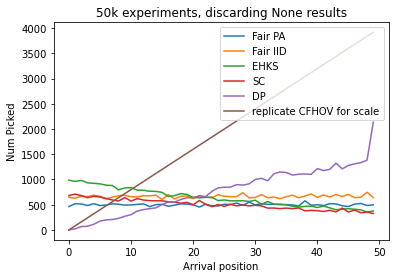

In [14]:
#Plotting the results for 50k experiments

arrivalPositionsChosenFairPA, a = runExperiment(algorithm="FairGeneralProphet", N_experimentReps=50000, 
                                                distribution_type="uniform", n_candidates=50)
    
arrivalPositionsChosenFairIID, b = runExperiment(algorithm="FairIIDProphet", N_experimentReps=50000, 
                                                distribution_type="uniform", n_candidates=50)
    
arrivalPositionsChosenSC, c = runExperiment(algorithm="SC", N_experimentReps=50000, 
                                                distribution_type="uniform", n_candidates=50)
    
arrivalPositionsChosenEHKS, d = runExperiment(algorithm="EHKS", N_experimentReps=50000, 
                                                distribution_type="uniform", n_candidates=50)
arrivalPositionsChosenDP, e = runExperiment(algorithm="DP", N_experimentReps=50000, 
                                                distribution_type="uniform", n_candidates=50)

plt.plot(range(0,50), arrivalPositionsChosenFairPA, label="Fair PA")
plt.plot(range(0,50), arrivalPositionsChosenFairIID, label="Fair IID")
plt.plot(range(0,50), arrivalPositionsChosenEHKS, label="EHKS")
plt.plot(range(0,50), arrivalPositionsChosenSC, label="SC")
plt.plot(range(0,50), arrivalPositionsChosenDP, label="DP")
plt.plot(range(0,50), range(0,4000,80), label="replicate CFHOV for scale")
plt.title("50k experiments, discarding None results")
plt.xlabel("Arrival position")
plt.ylabel("Num Picked")
plt.legend(loc="upper right")
plt.savefig("50kExperiments.png")

This led us to examining two approaches. One in which we increase the number of experiments to 100k, and one where we run 50k experiments and keep repeating each experiment untill we don't get a None. The first one has been done above, and seems to confirm the found results.

It is also worth noting that just skipping over None results does not lead to the same results, only increasing the number of experiments. As shown here

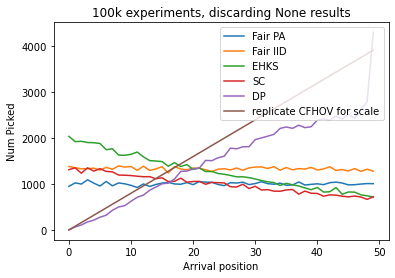

In [15]:
#Plotting the results for 100k experiments

arrivalPositionsChosenFairPA, a = runExperiment(algorithm="FairGeneralProphet", N_experimentReps=50000*2, 
                                                distribution_type="uniform", n_candidates=50)
    
arrivalPositionsChosenFairIID, b = runExperiment(algorithm="FairIIDProphet", N_experimentReps=50000*2, 
                                                distribution_type="uniform", n_candidates=50)
    
arrivalPositionsChosenSC, c = runExperiment(algorithm="SC", N_experimentReps=50000*2, 
                                                distribution_type="uniform", n_candidates=50)
    
arrivalPositionsChosenEHKS, d = runExperiment(algorithm="EHKS", N_experimentReps=50000*2, 
                                                distribution_type="uniform", n_candidates=50)

arrivalPositionsChosenDP, e = runExperiment(algorithm="DP", N_experimentReps=50000*2, 
                                                distribution_type="uniform", n_candidates=50)

plt.plot(range(0,50), arrivalPositionsChosenFairPA, label="Fair PA")
plt.plot(range(0,50), arrivalPositionsChosenFairIID, label="Fair IID")
plt.plot(range(0,50), arrivalPositionsChosenEHKS, label="EHKS")
plt.plot(range(0,50), arrivalPositionsChosenSC, label="SC")
plt.plot(range(0,50), arrivalPositionsChosenDP, label="DP")
plt.plot(range(0,50), range(0,4000,80), label="replicate CFHOV for scale")
plt.title("100k experiments, discarding None results")
plt.xlabel("Arrival position")
plt.ylabel("Num Picked")
plt.legend(loc="upper right")
plt.savefig("100kExperiments.png")

### Average values of chosen candidates

In [17]:
print("The average value of the chosen candidate in the uniform distribution: \n")
print("FairPA: ", mean(a), "(should be 0.501)")
print("FairIID: ", mean(b), "(should be 0.661)")
print("SK: ", mean(c), "(should be 0.499)")
print("EHKS: ", mean(d), "(should be 0.631)")
print("SP: ", mean(e), "(should be 0.751)")

The average value of the chosen candidate in the uniform distribution: 

FairPA:  0.49961658165241635 (should be 0.501)
FairIID:  0.6595991192803126 (should be 0.661)
SK:  0.4956801629152447 (should be 0.499)
EHKS:  0.632872067743629 (should be 0.631)
SP:  0.7491056624629919 (should be 0.751)



**Statement 1:** _In conclusion, for both settings, both our algorithms Algorithm 2 and Algorithm 3 provide perfect fairness, while giving 66.71% and 88.01% (for the uniform case), and 58.12% and 75.82% (for the binomial case), of the value of the optimal, but unfair, online algorithm._

Here the unfair online algorihtm must either SC or EHKS, something else is not mentioned about online algorithms. Also in the codebase, the unfair algorithms refer to these. Thus we will take a look at both, and see if these results are replicable.


In [20]:
# TotalValueFairPA = a
# TotalValueFairIID = b
# TotalValueFairSK = c
# TotalValueFairEHKS = d

print("Uniform case, for FairPA")
# print("Assuming SK as the 'optimal, but unfair, online algorithm' :", mean(a) / mean(c) *100, "%")
# print("Assuming EHKS as the 'optimal, but unfair, online algorithm' :", mean(a) / mean(d) *100, "%")
print("Assuming DP as the 'optimal, but unfair, online algorithm' :", mean(a) / mean(e) *100, "%")

print("\n Uniform case, for FairIID")
# print("Assuming SK as the 'optimal, but unfair, online algorithm' :", mean(b) / mean(c) *100, "%")
# print("Assuming EHKS as the 'optimal, but unfair, online algorithm' :", mean(b) / mean(d) *100, "%")
print("Assuming DP as the 'optimal, but unfair, online algorithm' :", mean(b) / mean(e) *100, "%")



Uniform case, for FairPA
Assuming DP as the 'optimal, but unfair, online algorithm' : 66.69507476551732 %

 Uniform case, for FairIID
Assuming DP as the 'optimal, but unfair, online algorithm' : 88.05154630811495 %


Both of these approaches thus do not (nearly) approach the results as presented in the paper, and seem to be verifiable in Figure 2 in the paper. Thus, the question is raised which algorithm is used to calculate the percentages mentioned in **Statement 1**.

## Binomial distribution

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
23

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


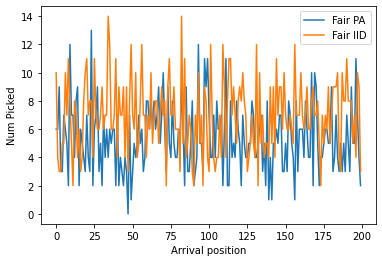

In [21]:
# input consists of 1000 samples from the binomial distribution with 1000 trials 
# and 1/2 probability of success of a single trial
n = 200
k = n # since each candidate is a group on its own
q, V = [1/n] * n , rng.binomial(n=1000, p=.5, size=n)

N_experimentReps = 2000
arrivalPositionsChosenFairPA, arrivalPositionsChosenFairIID = [0]*n, [0]*n

# Running experiment for the FairPA
for cnt in range(N_experimentReps):
#     print(cnt)
    if (cnt % 50 == 0) : print(cnt)
    q, V = [1/n] * n , rng.binomial(n=1000, p=.5, size=n)
    result = FairGeneralProphet(q, V, "binomial")
    if result != None:
        arrivalPositionsChosenFairPA[FairGeneralProphet(q, V, "binomial")] += 1
# print("Ran FairPA")

# Running experiment for the FairIID
for cnt in range(N_experimentReps):
#     print("2: ", cnt)
    if cnt % 50 : print(cnt)
    q, V = [1/n] * n , rng.binomial(n=1000, p=.5, size=n)
    if FairIIDProphet(V, "binomial") != None:
        arrivalPositionsChosenFairIID[FairIIDProphet(V, "binomial")] += 1
            
plt.plot(range(0,n), arrivalPositionsChosenFairPA, label="Fair PA")
plt.plot(range(0,n), arrivalPositionsChosenFairIID, label="Fair IID")
plt.xlabel("Arrival position")
plt.ylabel("Num Picked")
plt.legend(loc="upper right")